# Overview
The goal of this notebook is to leverage linear constraints of the form $A\bm x \leq \bm b$ to project exterior points back onto the boundary of the convex polytope defined by the constraints. This will enable a "sticky" interaction of the particles/agents/countries often used in meta-heuristic optimization algorithms with the boundaries of some feasible region.

There are two approaches to solving this problem: using an orthogonal projection, or by solving an intersection problem.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

## Define Constraints

In [2]:
# The corresponding half space definition for the polytope
A = np.array([[-1, 1], [1, 0], [0, -1]])
b = np.array([0, 2, -1])

# Vertices
vertices = np.array([[1, 1], [2, 1], [2, 2]])

## Plot Feasible Region

In [3]:
def plot_constraints_no_points():
    plt.fill(vertices[:, 0], vertices[:, 1], "lightblue", alpha=0.5, label="Feasible Region")
    plt.xlim(0, 3)
    plt.ylim(0, 3)

    # Plot the lines y=x, y=1, x=1
    x = np.linspace(-1, 3, 100)
    y = x
    plt.plot(x, y, label='y=x')
    plt.axhline(y=1, color='r', linestyle='-', label='y=1')
    plt.axvline(x=2, color='g', linestyle='-', label='x=1')

def plot_constraints(x_int, x_ext):
    plot_constraints_no_points()
    # Plot the line between the interior and exterior point
    plt.plot(x_int[0], x_int[1], 'ro', label='Interior Point')
    plt.plot(x_ext[0], x_ext[1], 'bo', label='Exterior Point')
    plt.plot([x_int[0], x_ext[0]], [x_int[1], x_ext[1]], 'k--', label='Line between Interior and Exterior')



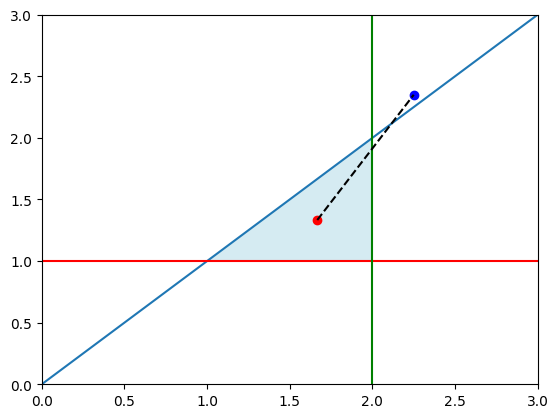

In [4]:
# Place an interior and exterior point inside the polytope
x_int = np.mean(vertices, axis=0)
x_ext = np.array([2.25, 2.35])

plot_constraints(x_int, x_ext)

In this case multiple constraints are violated when we evaluate $A$ against the exterior point. This corresponds with the visualization, where multiple hyperplanes have been intersected by the line segment between the interior and exterior points. But, we only care about the first hyperplane it intersected.

## Approach One: Intersect Line with Polytope
In this approach we have some subset of the linear constraints that are violated, in other words, a subset of the rows of $A$. We can parameterize the line connecting our interior point with the exterior point as $$\lambda  \bm x_{int} + (1-\lambda)\bm x_{ext}$$

Then the problem is to find the minimum $\lambda_{min} \in [0,1]$ with $$A_i(\lambda_{min}  \bm x_{int} + (1-\lambda_{min})\bm x_{ext})=b_i.$$  

This suggest the following procedure:
1. Identify the subset of constraints that are violated for $\bm x_{ext}$, call this $A^*$ (with corresponding $\bm b^*$)
2. Solve $$\boldsymbol \lambda=\frac{\bm b^*-A^*\bm x_{ext}}{A^*(\bm x_{int} -\bm x_{ext})}$$ If $A^*(\bm x_{int} -\bm x_{ext})=0$, in other words, the vector is parallel to the hyperplane, the line will never intersect.
3. Take the minimum over all violated constraints to find $\lambda_{min}$. Then $$\hat{\bm x}= \lambda_{min} \bm x_{int} + (1-\lambda_{min})\bm x_{ext}$$

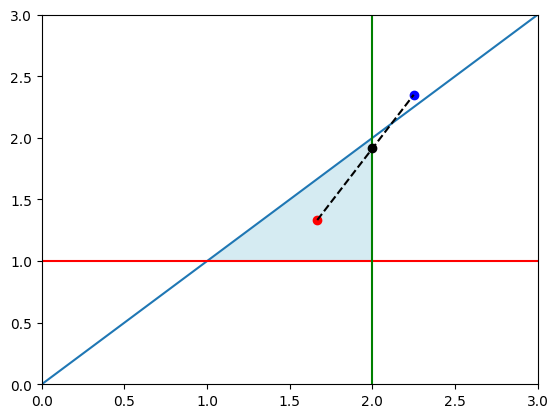

In [5]:
# Identify violated constraints
violated = A @ x_ext > b

# Take the rows from A and b that are violated
A_violated = A[violated]
b_violated = b[violated]

# Solve for lambda
# Check for division by zero
l = (b_violated - A_violated @ x_int) / (A_violated @ (x_ext - x_int))

# Find the minimum lambda
# Check for values not in [0,1]
l_min = np.min(l)

# Use the parameterized line to find the intersection point using the min
x_hat = x_int + l_min * (x_ext - x_int)

# Plot the intersection point
plot_constraints(x_int, x_ext)
plt.plot(x_hat[0], x_hat[1], 'ko', label='Intersection Point')

In [6]:
def project_linear_intersection(A, b, x_int, x_ext):
    # Identify violated constraints
    violated = A @ x_ext > b

    # Take the rows from A and b that are violated
    A_violated = A[violated]
    b_violated = b[violated]

    # Solve for lambda
    # Check for division by zero
    l = (b_violated - A_violated @ x_int) / (A_violated @ (x_ext - x_int))

    # Find the minimum lambda
    # Check for values not in [0,1]
    l_min = np.min(l)

    # Use the parameterized line to find the intersection point using the min
    x_hat = x_int + l_min * (x_ext - x_int)
    return x_hat

## Approach Two: Orthogonal Projection
For this approach, we will project the exterior point $\bm x_{ext}$ onto each of the violated hyperplanes sequentially. Since we know the normal vector for a given bounding hyperplane (if $A_i$ is a row in the constraint matrix, it is also the normal vector to the bounding hyperplane), we can obtain a basis for the hyperplane defined by $A_i\bm x = b_i$ by solving for a single point $x_0$ (e.g. by setting all but one entry in $x$ equal to 0), then finding the null space of vectors orthogonal to the normal: $b_i = \{ \bm x \mid A_i\bm x=0 \}$. Collecting the basis into a matrix $B$, we can use the standard projection operation: $$B(B'B)^{-1}B'$$

However, since the boundary is a hyperplane and not just any subspace, and the normal vector is known (it's just $A_i$), we can take a more direct approach to compute the affine projection of $\bm x_{ext}$: $$\bm x^*=\bm x_{ext} - \frac{A_i'\bm x_{ext} - b_i}{||A_i||^2}A_i$$

In [7]:
def project(A, x, b):
    proj = x - (A @ x - b) / (A @ A) * A
    return proj

def project_alternating(A, b, x, history=None):
    if history is None:
        history = [x]
    violated = A @ x > b
    if np.all(~violated):
        return np.array(history)
    A_violated = A[violated]
    b_violated = b[violated]
    x_proj = x
    new_history = [x]
    for i in range(len(A_violated)):
        x_proj = project(A_violated[i], x_proj, b_violated[i])
        new_history.append(x_proj)
    return project_alternating(A, b, x_proj, history + new_history)

## Test Cases
### Method of Alternating Projections

In [8]:
# Generate vertices of the regular n-gon
def generate_polygon_vertices(n):
    x = np.cos(2 * np.pi * np.arange(n) / n)
    y = np.sin(2 * np.pi * np.arange(n) / n)
    vertices = np.column_stack((x, y))
    return vertices

# Extract the intercept and slope for each line
def compute_boundary_lines(vertices):
    hull = ConvexHull(vertices)
    lines = []    
    for simplex in hull.simplices:
        point1, point2 = vertices[simplex]
        x1, y1 = point1
        x2, y2 = point2

        if x2 - x1 != 0:
            m = (y2 - y1) / (x2 - x1)
            b = y1 - m * x1
            lines.append((m, b))
        else: # vertical lines
            lines.append((None, x1))

    return lines

# Use the normal equations to compute the constraint matrix
def compute_constraint_matrix(vertices):
    hull = ConvexHull(vertices)
    A = hull.equations[:, :-1]
    b = -hull.equations[:, -1]
    return A, b

# Plot constraint lines
def plot_polygon_constraints(vertices):
    lines = compute_boundary_lines(vertices)
    for m, b in lines:
        if m is not None:
            x = np.linspace(-10, 10, 100)
            y = m * x + b
            plt.plot(x, y)
        else:
            plt.axvline(x=b)
    plt.fill(vertices[:, 0], vertices[:, 1], "lightblue", alpha=0.5, label="Feasible Region")
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)

# Plot each point in the MAP history with connecting lines
def plot_history(history):
    for i in range(1, len(history)):
        plt.plot(history[i-1][0], history[i-1][1], 'ro')
        plt.plot([history[i-1][0], history[i][0]], [history[i-1][1], history[i][1]], 'k--')
    # Plot first and last points in different colors
    plt.plot(history[0][0], history[0][1], 'go')
    plt.plot(history[-1][0], history[-1][1], 'bo')

# Generate examples for the MAP algorithm
def make_map_examples(n, x_exts):
    verts = generate_polygon_vertices(n)
    A, b = compute_constraint_matrix(verts)
    plot_polygon_constraints(verts)
    for x_ext in x_exts:
        history = project_alternating(A, b, x_ext)
        plot_history(history)

# Generate examples for the linear projection algorithm
def make_linear_examples(n, x_exts):
    verts = generate_polygon_vertices(n)
    A, b = compute_constraint_matrix(verts)
    plot_polygon_constraints(verts)

    x_int = np.array([0, 0])
    for x_ext in x_exts:
        x_hat = project_linear_intersection(A, b, x_int, x_ext)
        plt.plot(0, 0, 'bo')
        plt.plot(x_ext[0], x_ext[1], 'go')
        plt.plot(x_hat[0], x_hat[1], 'ro')

        # Draw line between x_int and x_ext
        plt.plot([x_int[0], x_ext[0]], [x_int[1], x_ext[1]], 'k--')

In [9]:
x_exts = [[0.25, 1.5], [-1.5, 1.5], [1.5, 0], [1, -1.5], [-1, -1.5], [-2, -0.5]]

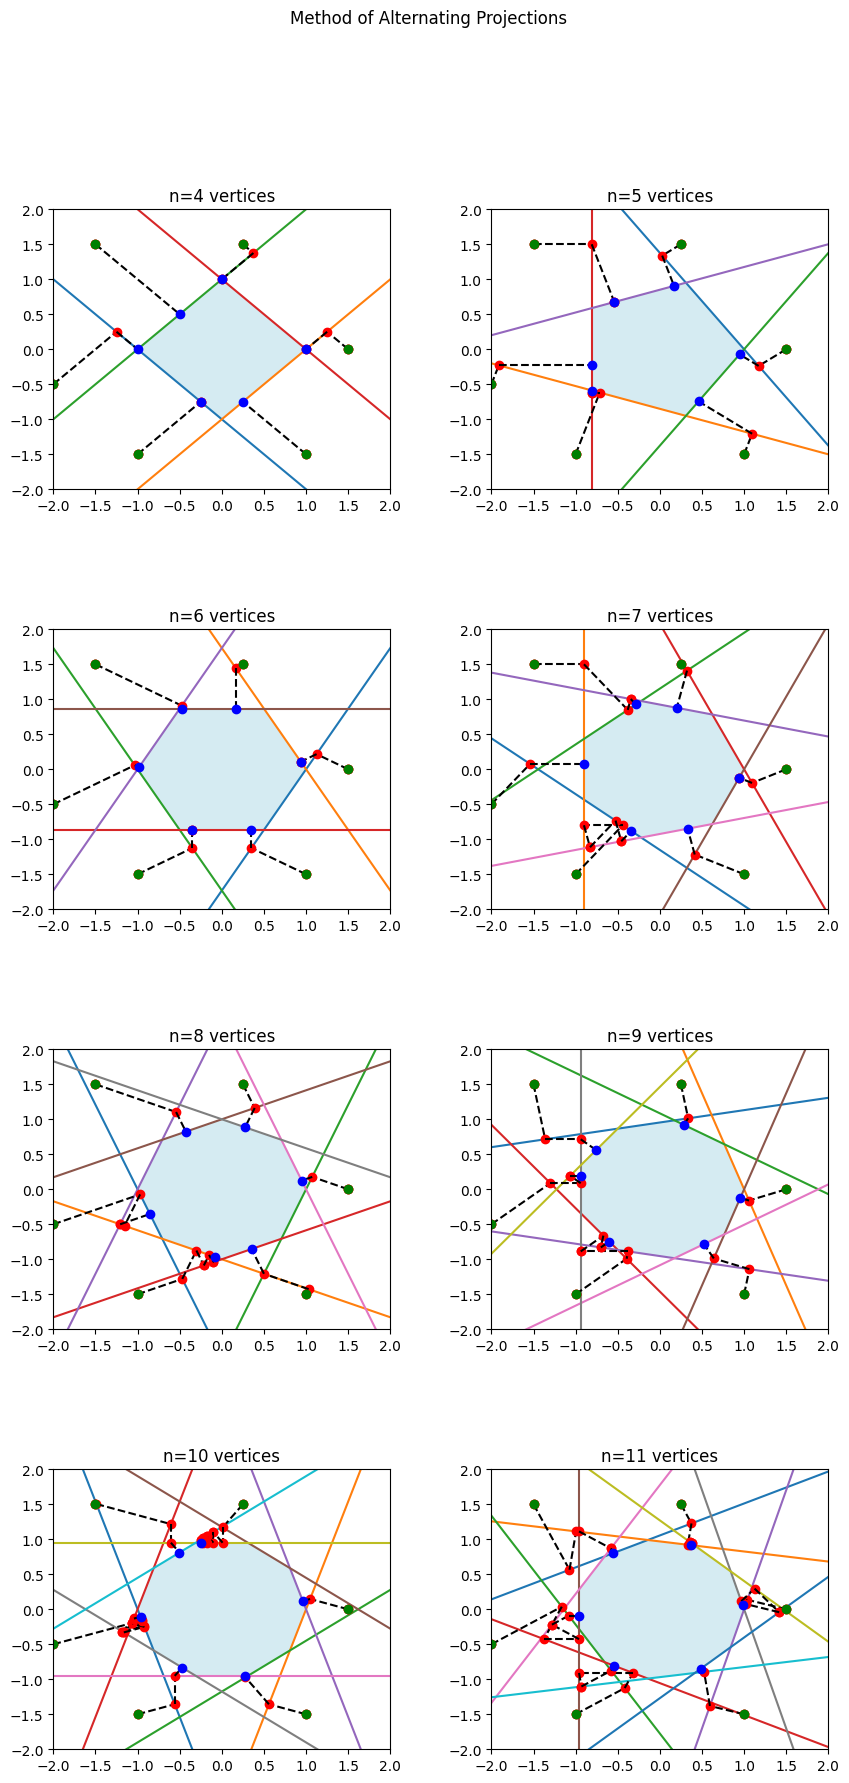

In [10]:
fig, axes = plt.subplots(4, 2, figsize=(10, 20))
fig.suptitle("Method of Alternating Projections")
plt.subplots_adjust(hspace=0.5, wspace=0.3)
for i, n in enumerate(range(4, 12)):
    ax = axes[i // 2, i % 2]
    plt.sca(ax)
    make_map_examples(n, x_exts)
    ax.set_title(f"n={n} vertices")
plt.savefig('map_polytope_projection.png')
plt.show()

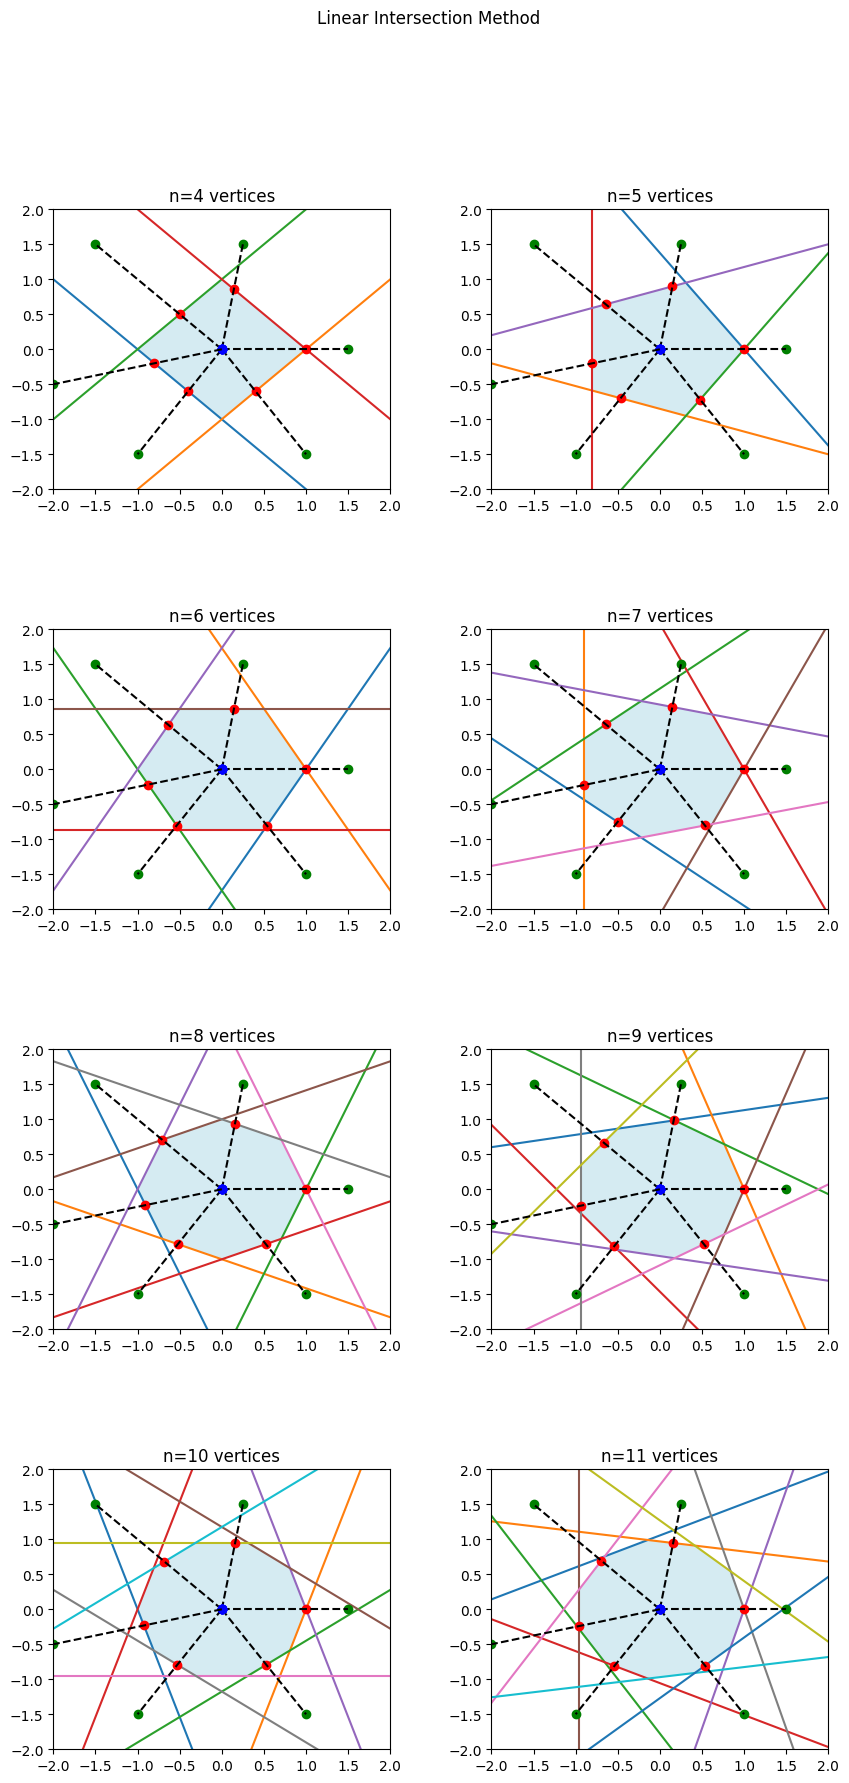

In [11]:
fig, axes = plt.subplots(4, 2, figsize=(10, 20))
fig.suptitle("Linear Intersection Method")
plt.subplots_adjust(hspace=0.5, wspace=0.3)
for i, n in enumerate(range(4, 12)):
    ax = axes[i // 2, i % 2]
    plt.sca(ax)
    make_linear_examples(n, x_exts)
    ax.set_title(f"n={n} vertices")
plt.savefig('linear_polytope_projection.png')
plt.show()